In [ ]:
!pip install --upgrade tensorflow keras

In [ ]:
!pip install pydicom pycaret

In [ ]:
!pip install --upgrade pycaret


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.18.0


# final_model = tf.keras.models.load_model('/content/drive/MyDrive/manual_cnn_model.h5') The Pycarat one doesn't work so we made one dummy one for this GradCam


Applying Grad-CAM to VGG16 layers...
Applying Grad-CAM to Layer: block1_conv1


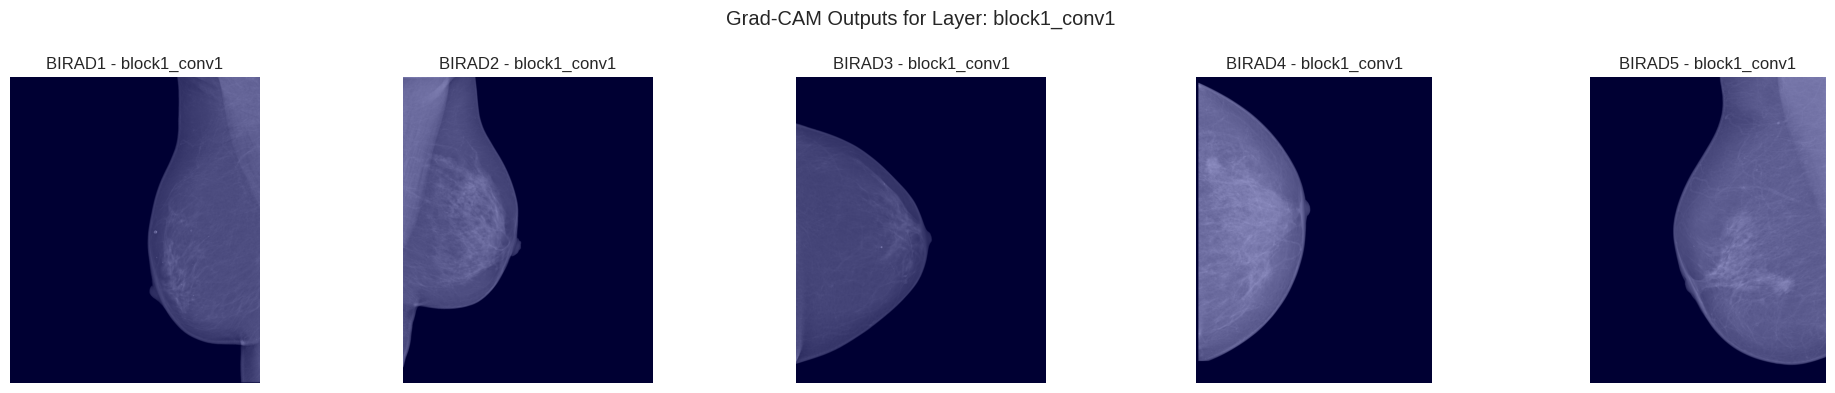

Applying Grad-CAM to Layer: block1_conv2


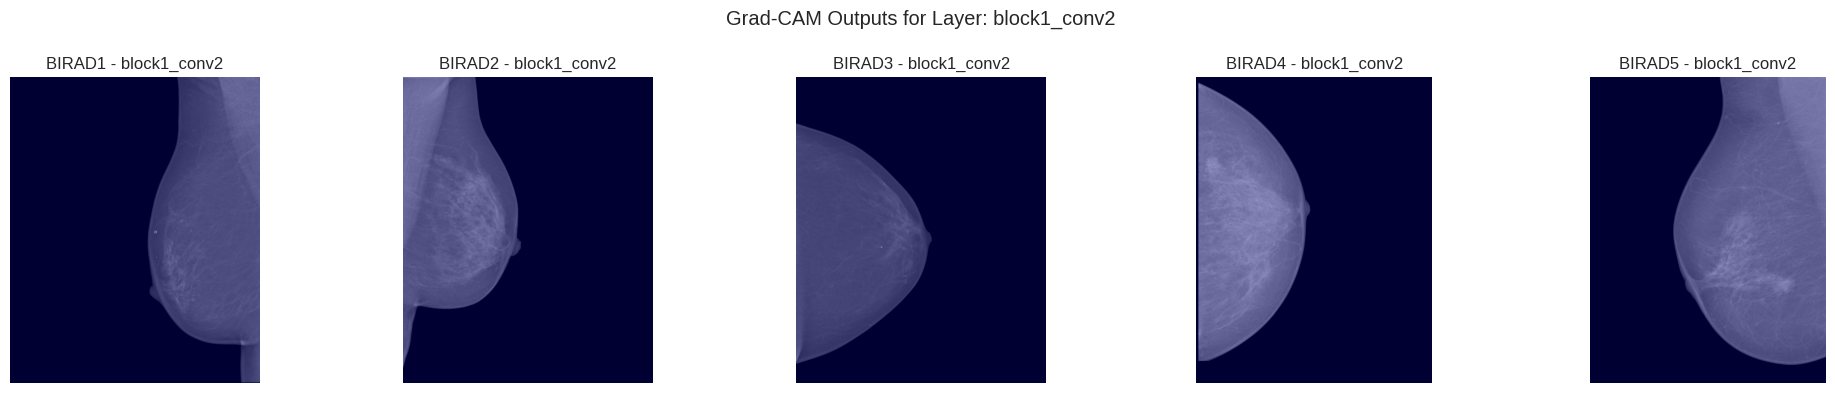

Applying Grad-CAM to Layer: block2_conv1


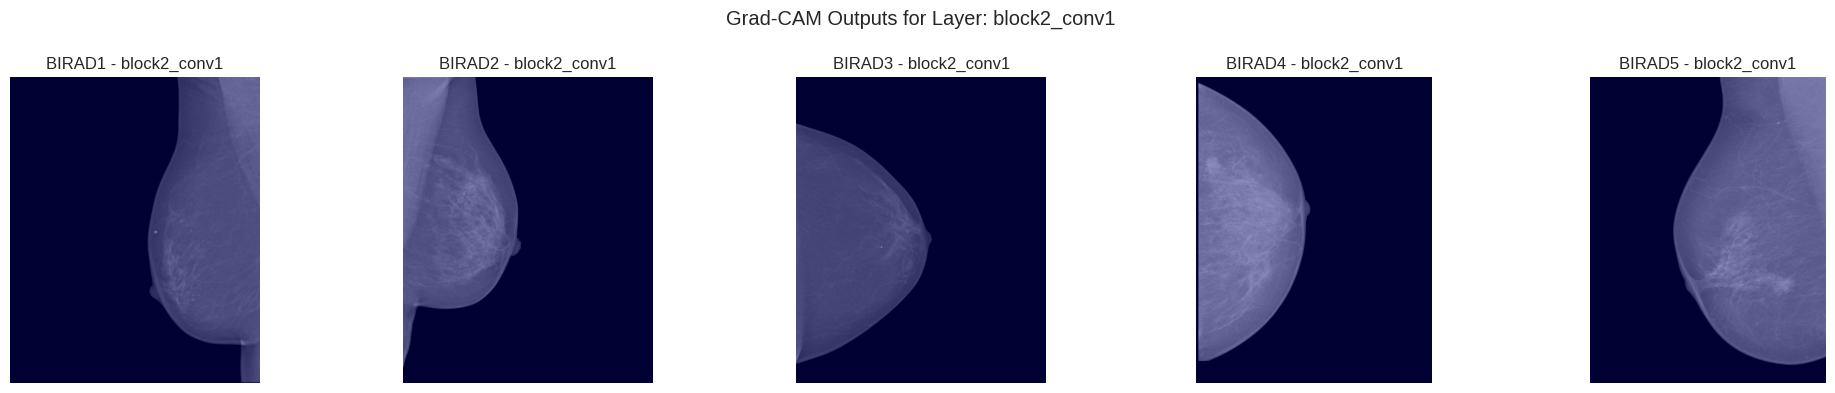

Applying Grad-CAM to Layer: block2_conv2


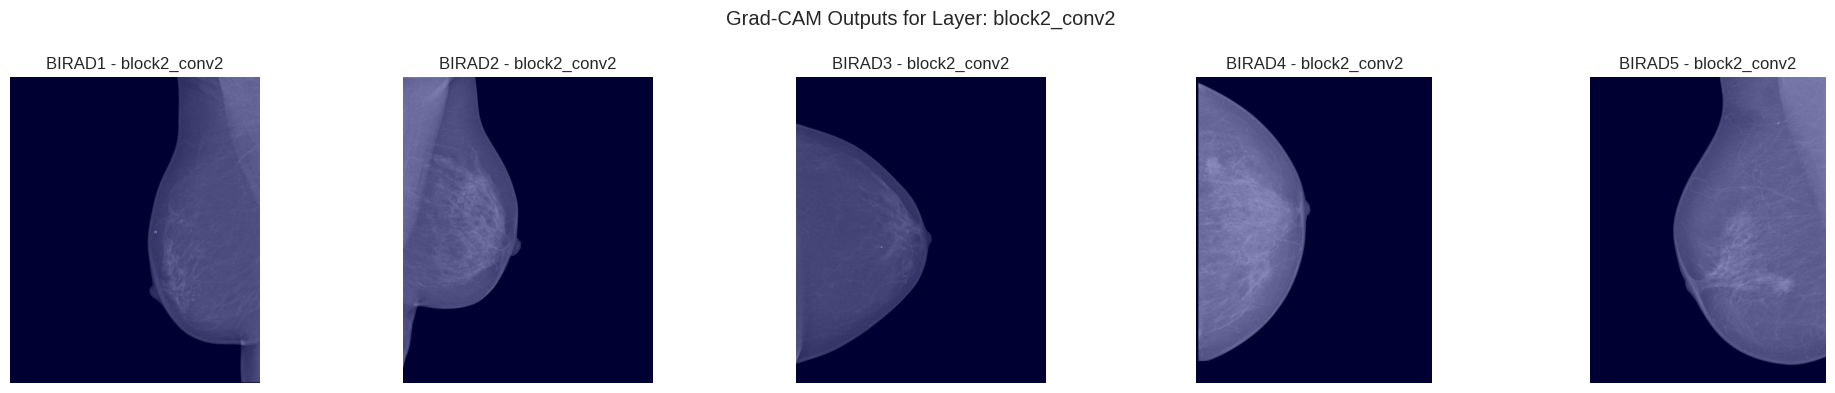

Applying Grad-CAM to Layer: block3_conv1


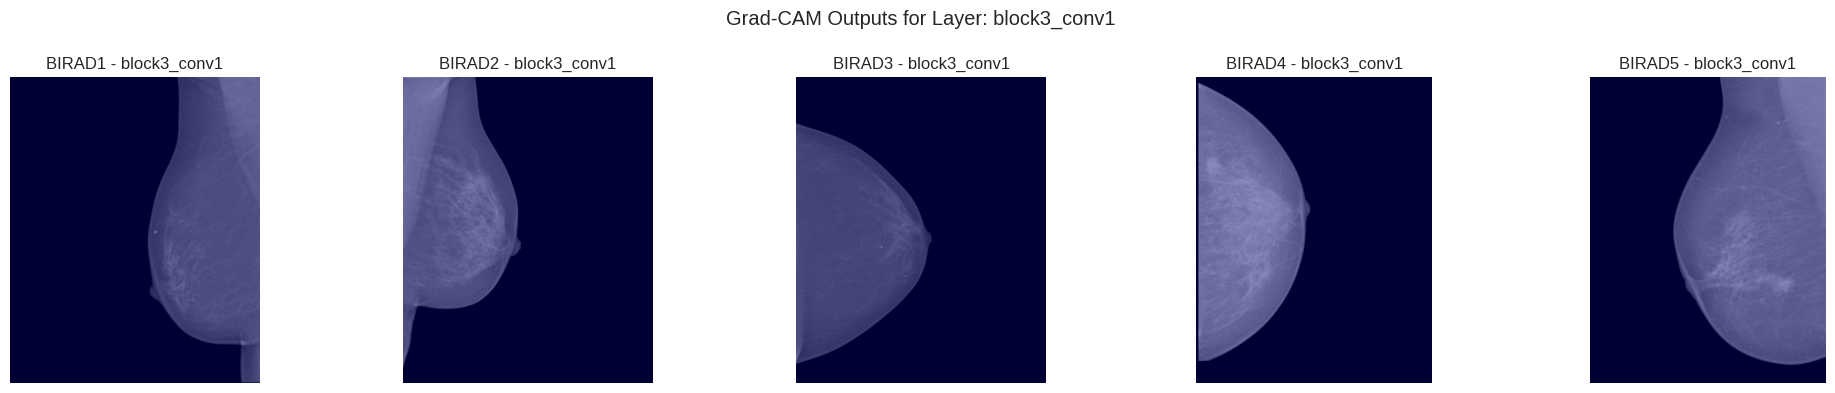

Applying Grad-CAM to Layer: block3_conv2


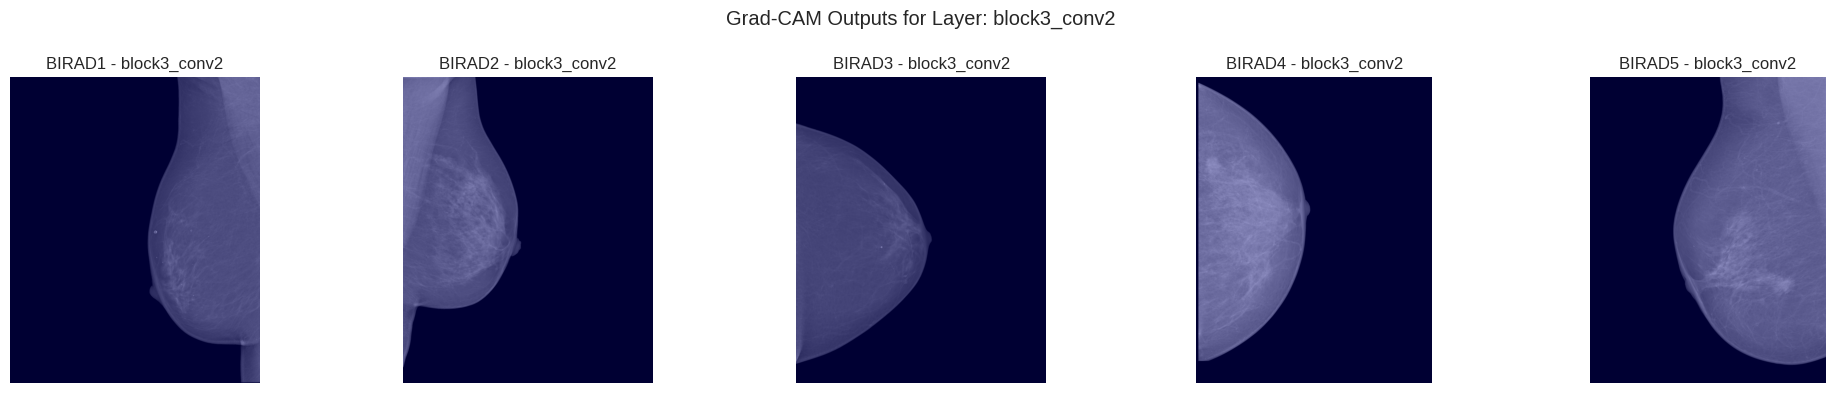

Applying Grad-CAM to Layer: block3_conv3


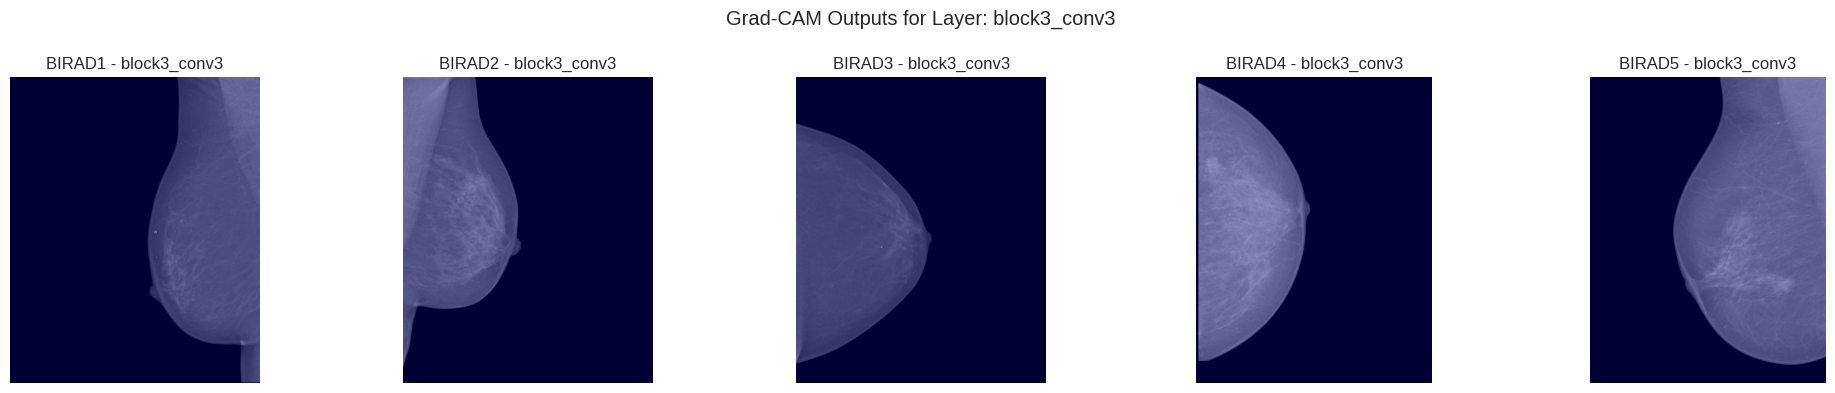

Applying Grad-CAM to Layer: block4_conv1


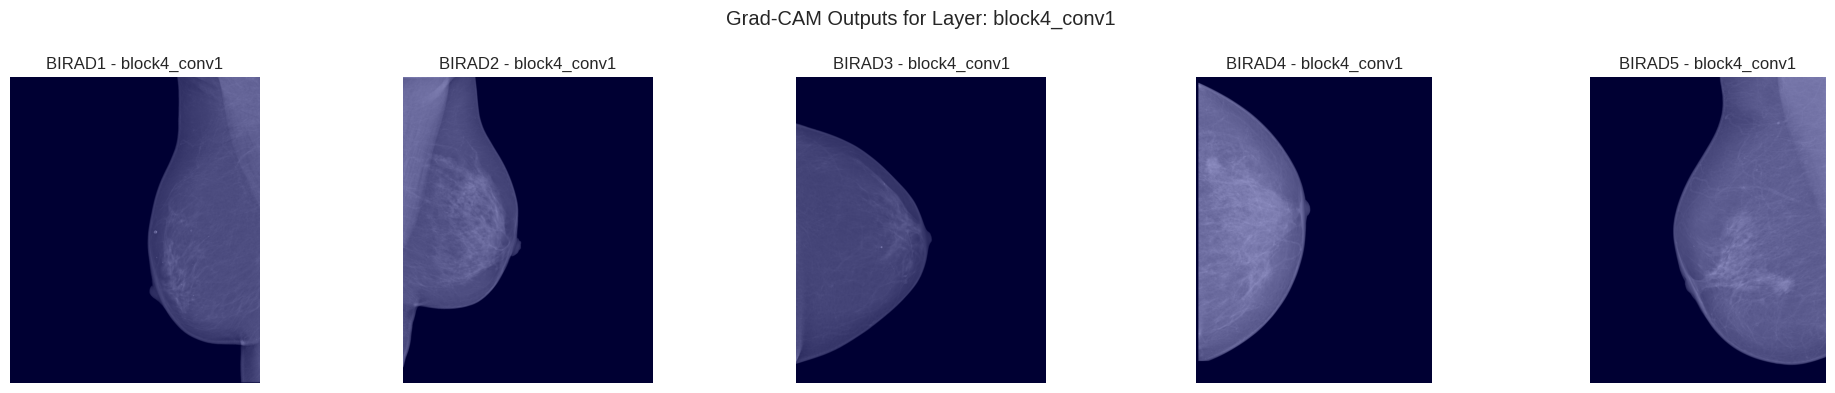

Applying Grad-CAM to Layer: block4_conv2


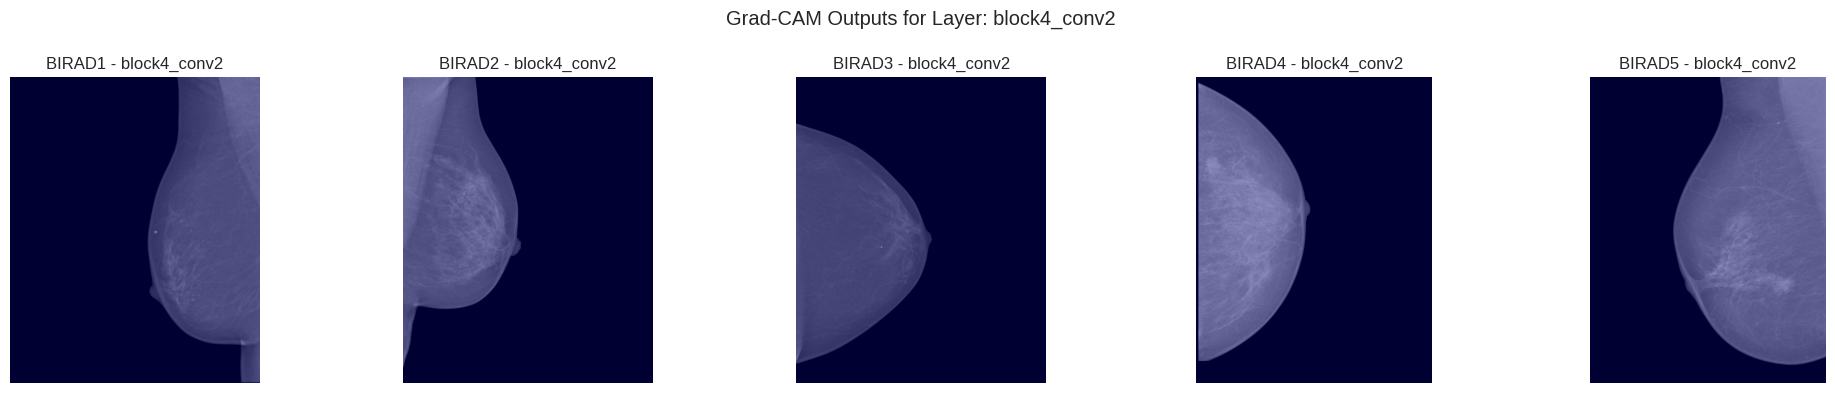

Applying Grad-CAM to Layer: block4_conv3


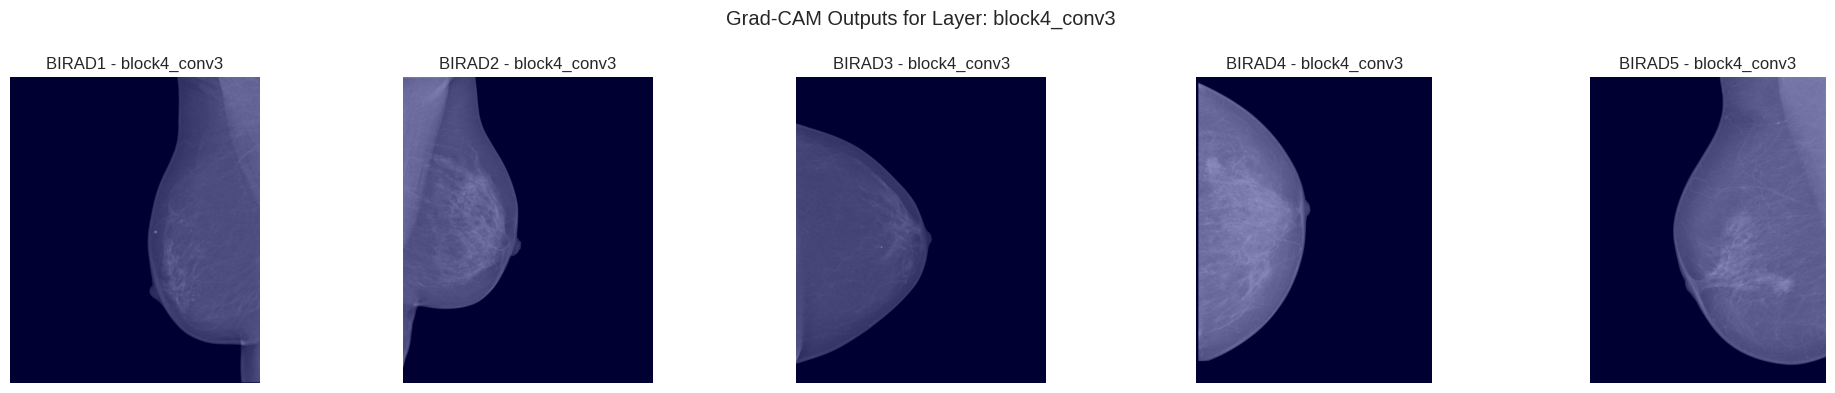

Applying Grad-CAM to Layer: block5_conv1


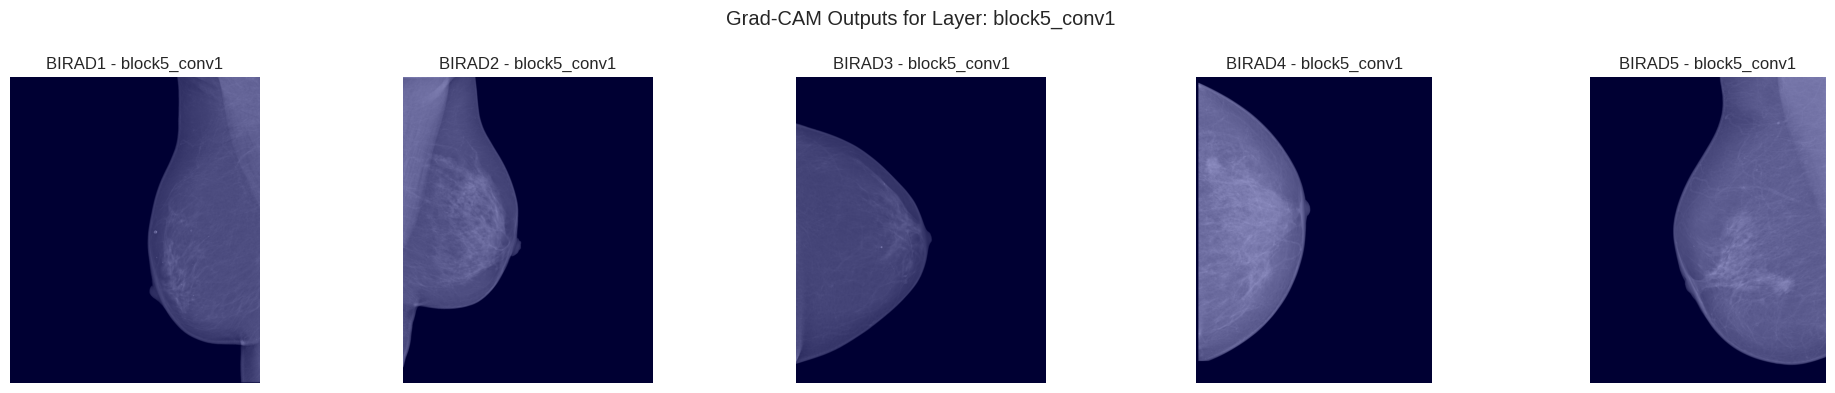

Applying Grad-CAM to Layer: block5_conv2


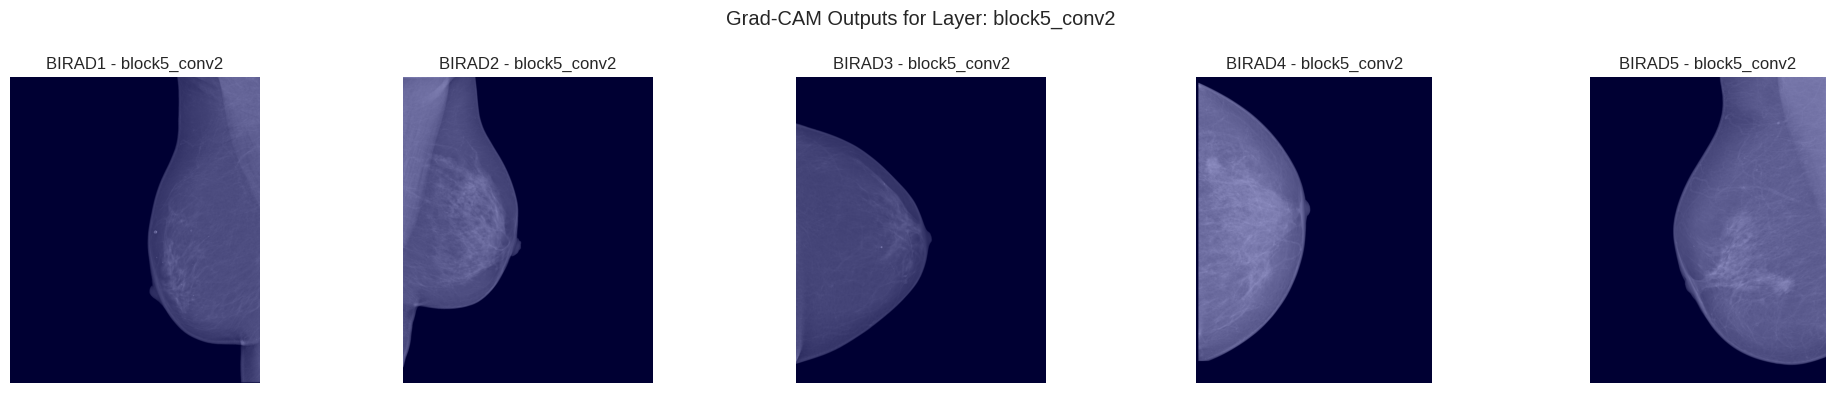

Applying Grad-CAM to Layer: block5_conv3


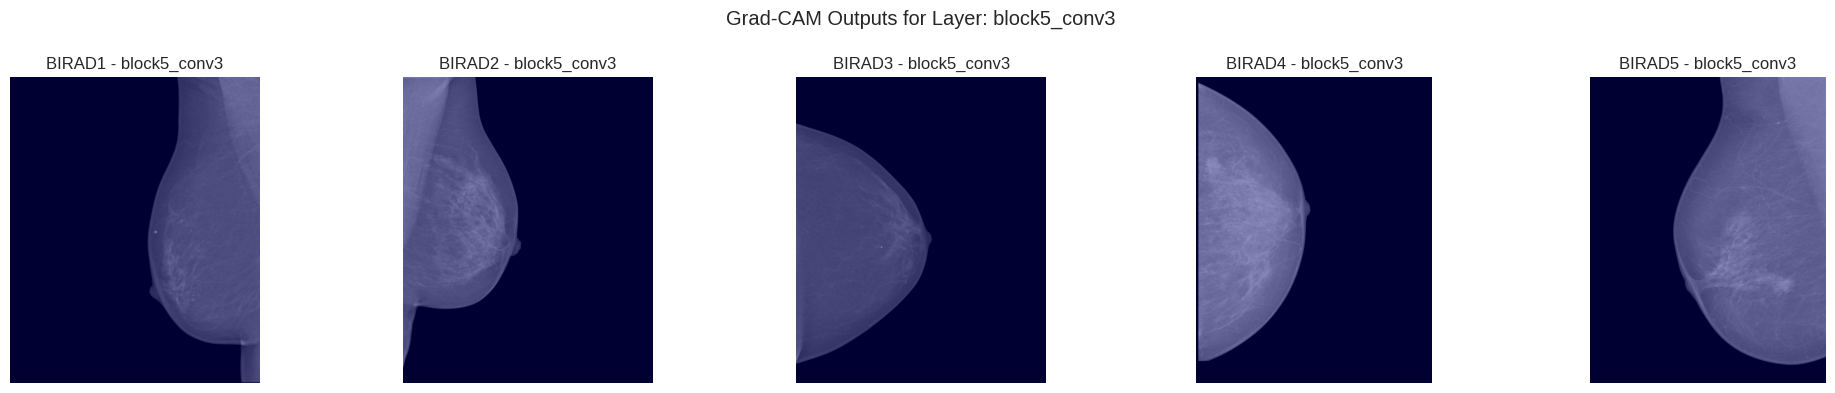

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Reshape
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
tf.random.set_seed(1)
np.random.seed(1)

# Define paths for each BIRAD class (with image file paths)
birad_classes = {
    "BIRAD1": "/content/Birad1.jpg",
    "BIRAD2": "/content/Birad2.jpg",
    "BIRAD3": "/content/Birad3.jpg",
    "BIRAD4": "/content/Birad4.jpg",
    "BIRAD5": "/content/Birad5.jpg",
}

# Step 1: Rebuild the VGG16 architecture without the top layers
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)


# cnn_vgg = Model(inputs=base_model.input, outputs=x)

# Define your final model (assuming it requires 32x32x1 input)
final_model = tf.keras.models.load_model('/content/drive/MyDrive/manual_cnn_model.h5')

# Step 2: Ensure compatibility with final_model
# Assuming the final_model expects a 32x32x1 input, we need to reshape the VGG16 output
# into that shape before passing it to final_model

# Reshape the output to match (None, 32, 32, 1)
x = Reshape((32, 32, 1))(x)  # Modify shape as needed

# Step 3: Combine the models
combined_output = final_model(x)  # Pass reshaped output to the final model
combined_model = Model(inputs=base_model.input, outputs=combined_output)

# Function to preprocess the image
def preprocess_image(img_path):
    img_rgb = cv2.imread(img_path)
    img_rgb = cv2.resize(img_rgb, (224, 224))
    x = np.expand_dims(img_rgb, axis=0)
    x = tf.keras.applications.vgg16.preprocess_input(x)
    return x

# Grad-CAM function
def grad_cam(model, img, layer_name, class_index):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)

    if np.max(heatmap) != 0:
        heatmap /= np.max(heatmap)

    return heatmap

# Function to overlay heatmap on original image
def overlay_heatmap(img_path, heatmap, alpha=0.4):
    img_rgb = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img_rgb.shape[1], img_rgb.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(heatmap, alpha, img_rgb, 1 - alpha, 0)
    return superimposed_img

# Iterate over each convolutional layer in VGG16 and apply Grad-CAM for each image
print("Applying Grad-CAM to VGG16 layers...")
# for layer in cnn_vgg.layers:
for layer in combined_model.layers:
    if 'conv' in layer.name:  # Check if the layer is a convolutional layer
        layer_name = layer.name
        print(f"Applying Grad-CAM to Layer: {layer_name}")

        # Set up plot for side-by-side comparison
        plt.figure(figsize=(20, 4))  # Adjust width as necessary for the number of images
        for i, (class_name, img_path) in enumerate(birad_classes.items()):
            # Preprocess the image
            preprocessed_img = preprocess_image(img_path)

            # Perform Grad-CAM on the current convolutional layer for the image
            cnn_vgg_heatmap = grad_cam(combined_model, preprocessed_img, layer_name, class_index=0)

            # Generate Grad-CAM visualization
            cnn_vgg_cam = overlay_heatmap(img_path, cnn_vgg_heatmap)

            # Display results
            plt.subplot(1, len(birad_classes), i + 1)
            plt.imshow(cv2.cvtColor(cnn_vgg_cam, cv2.COLOR_BGR2RGB))
            plt.title(f'{class_name} - {layer_name}')
            plt.axis('off')

        plt.suptitle(f'Grad-CAM Outputs for Layer: {layer_name}')
        plt.tight_layout()
        plt.show()

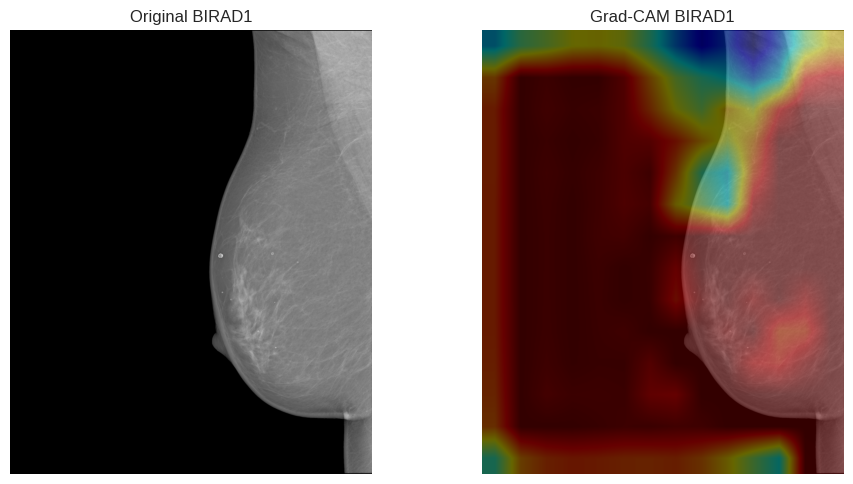

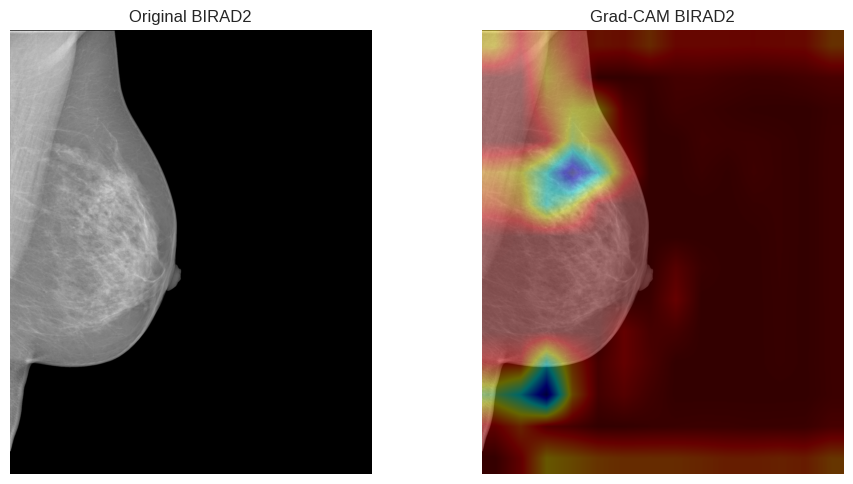

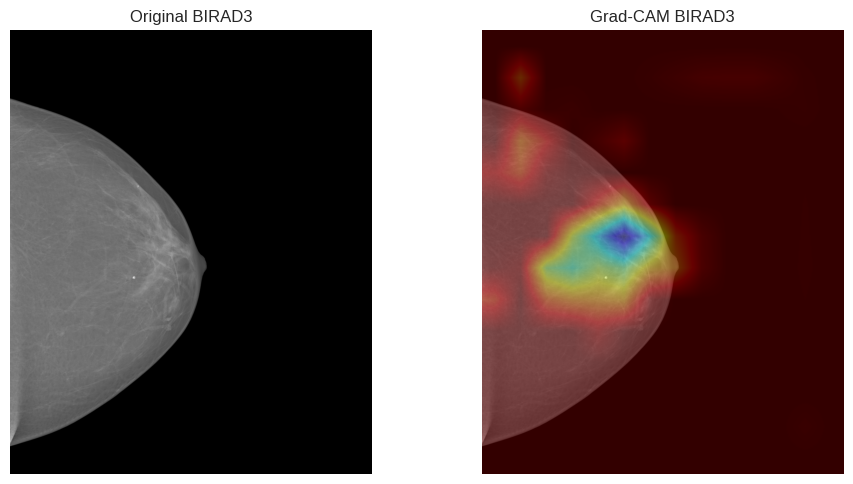

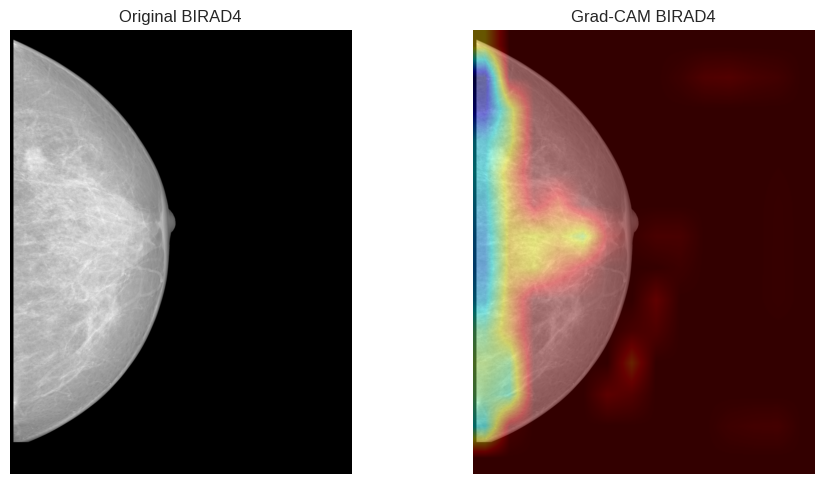

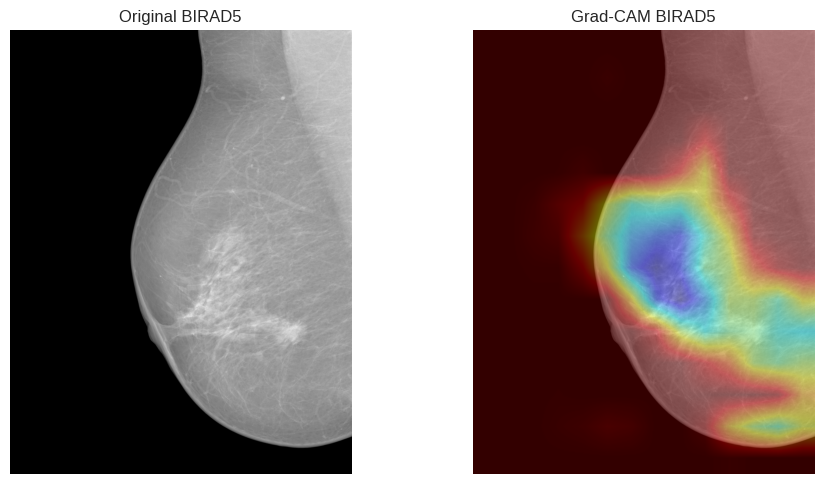

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Reshape
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

def create_gradcam_model(input_shape=(224, 224, 3), num_classes=5):
    """
    Create a VGG16-based model with Grad-CAM compatibility

    Args:
        input_shape (tuple): Input image shape
        num_classes (int): Number of classification classes

    Returns:
        Keras Model ready for Grad-CAM
    """
    # Base VGG16 model without top layers
    base_model = VGG16(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )

    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=x)

    return model, base_model

def preprocess_image(img_path, target_size=(224, 224)):
    """
    Preprocess image for model input

    Args:
        img_path (str): Path to image file
        target_size (tuple): Resize dimensions

    Returns:
        Preprocessed image array
    """
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img_array = np.expand_dims(img, axis=0)
    img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
    return img_array

def grad_cam(model, base_model, img, class_index, last_conv_layer_name='block5_conv3'):
    """
    Generate Grad-CAM heatmap

    Args:
        model (Keras Model): Full classification model
        base_model (Keras Model): Base feature extraction model
        img (numpy array): Preprocessed input image
        class_index (int): Target class index
        last_conv_layer_name (str): Name of last convolutional layer

    Returns:
        Grad-CAM heatmap
    """
    # Create gradient model
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [base_model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img)
        loss = predictions[:, class_index]

    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)

    # Global average pooling of gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight feature maps
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Normalize and ReLU
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

def overlay_heatmap(img_path, heatmap, alpha=0.4):
    """
    Overlay Grad-CAM heatmap on original image

    Args:
        img_path (str): Path to original image
        heatmap (numpy array): Grad-CAM heatmap
        alpha (float): Transparency of heatmap

    Returns:
        Superimposed image
    """
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)
    return superimposed_img

def main():
    # Define image paths
    birad_classes = {
        "BIRAD1": "/content/Birad1.jpg",
        "BIRAD2": "/content/Birad2.jpg",
        "BIRAD3": "/content/Birad3.jpg",
        "BIRAD4": "/content/Birad4.jpg",
        "BIRAD5": "/content/Birad5.jpg"
    }

    # Create model
    model, base_model = create_gradcam_model(num_classes=len(birad_classes))

    # Optional: Load pre-trained weights if available
    # model.load_weights('/path/to/your/weights.h5')

    # Visualize Grad-CAM for each image
    for class_index, (class_name, img_path) in enumerate(birad_classes.items()):
        # Preprocess image
        preprocessed_img = preprocess_image(img_path)

        # Generate Grad-CAM
        heatmap = grad_cam(model, base_model, preprocessed_img, class_index)
        cam_image = overlay_heatmap(img_path, heatmap)

        # Plot results
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title(f'Original {class_name}')
        plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title(f'Grad-CAM {class_name}')
        plt.imshow(cam_image)
        plt.axis('off')

        plt.tight_layout()
        plt.show()

if __name__ == '__main__':
    main()

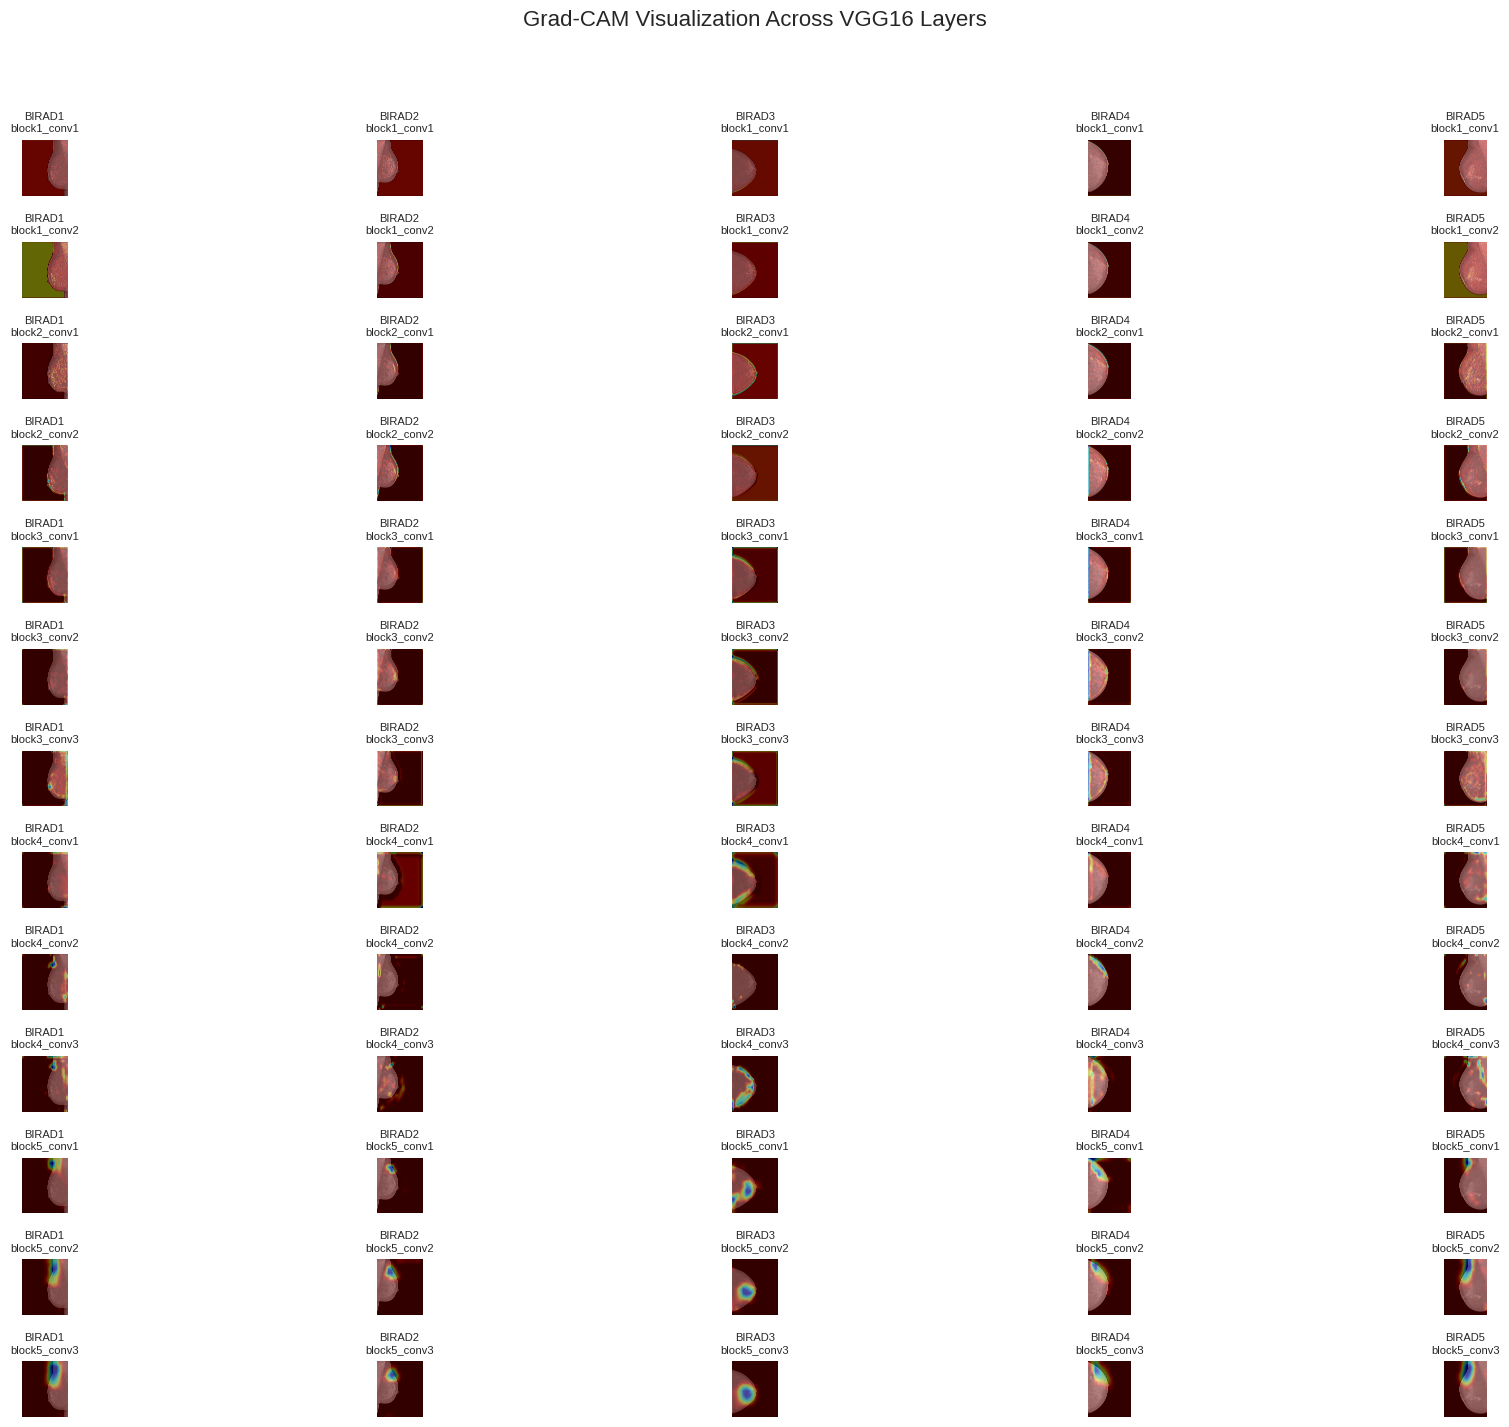

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

def create_base_model(input_shape=(224, 224, 3)):
    """Create VGG16 base model for feature extraction"""
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    return base_model

def preprocess_image(img_path, target_size=(224, 224)):
    """Preprocess image for model input"""
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img_array = np.expand_dims(img, axis=0)
    img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
    return img_array

def grad_cam(model, img, layer_name):
    """Generate Grad-CAM heatmap for a specific layer"""
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img)
        loss = tf.reduce_max(predictions)

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    heatmap = np.maximum(heatmap, 0)
    if np.max(heatmap) != 0:
        heatmap /= np.max(heatmap)

    return heatmap

def overlay_heatmap(img_path, heatmap, alpha=0.4):
    """Overlay Grad-CAM heatmap on original image"""
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    return cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)

def visualize_gradcam():
    """Comprehensive Grad-CAM visualization for all layers and BIRAD images"""
    # Define image paths
    birad_classes = {
        "BIRAD1": "/content/Birad1.jpg",
        "BIRAD2": "/content/Birad2.jpg",
        "BIRAD3": "/content/Birad3.jpg",
        "BIRAD4": "/content/Birad4.jpg",
        "BIRAD5": "/content/Birad5.jpg"
    }

    # Create base VGG16 model
    base_model = create_base_model()

    # Identify convolutional layers
    conv_layers = [layer.name for layer in base_model.layers if 'conv' in layer.name]

    # Setup plot
    plt.figure(figsize=(20, 15))
    plt.suptitle('Grad-CAM Visualization Across VGG16 Layers', fontsize=16)

    # Iterate through layers and images
    for i, layer_name in enumerate(conv_layers):
        for j, (class_name, img_path) in enumerate(birad_classes.items()):
            # Compute subplot index
            subplot_idx = i * len(birad_classes) + j + 1
            plt.subplot(len(conv_layers), len(birad_classes), subplot_idx)

            # Preprocess image
            preprocessed_img = preprocess_image(img_path)

            # Generate Grad-CAM
            heatmap = grad_cam(base_model, preprocessed_img, layer_name)
            cam_image = overlay_heatmap(img_path, heatmap)

            # Display image
            plt.imshow(cam_image)
            plt.title(f'{class_name}\n{layer_name}', fontsize=8)
            plt.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Run visualization
visualize_gradcam()

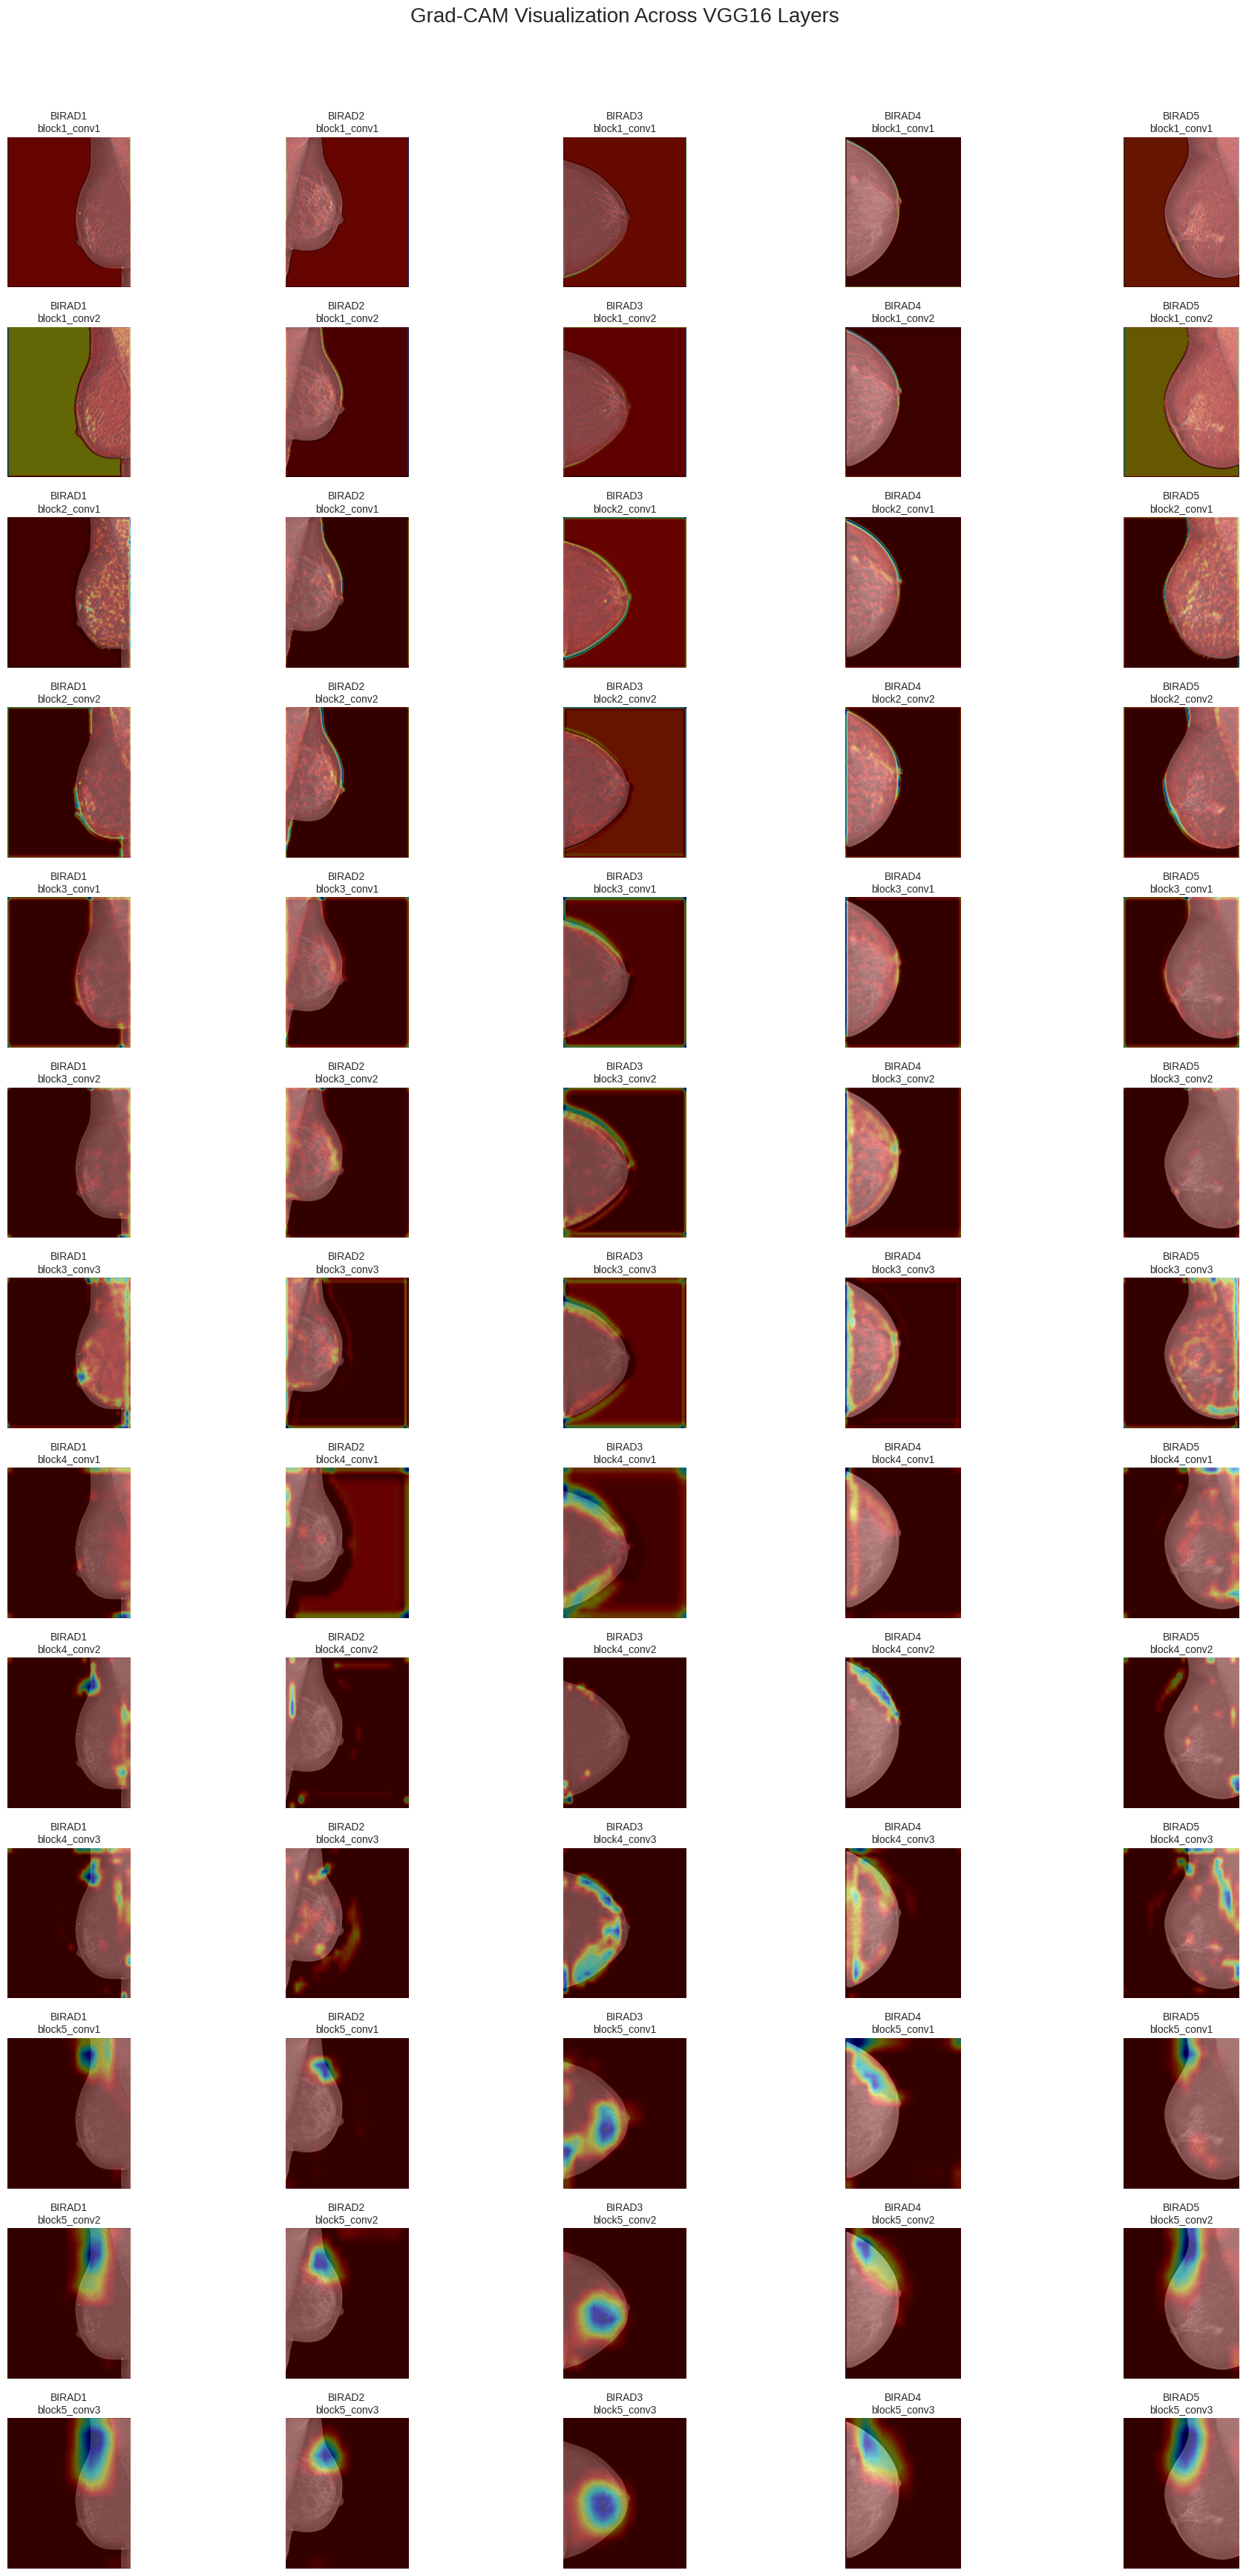

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

def create_base_model(input_shape=(224, 224, 3)):
    """Create VGG16 base model for feature extraction"""
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    return base_model

def preprocess_image(img_path, target_size=(224, 224)):
    """Preprocess image for model input"""
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img_array = np.expand_dims(img, axis=0)
    img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
    return img_array

def grad_cam(model, img, layer_name):
    """Generate Grad-CAM heatmap for a specific layer"""
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img)
        loss = tf.reduce_max(predictions)

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    heatmap = np.maximum(heatmap, 0)
    if np.max(heatmap) != 0:
        heatmap /= np.max(heatmap)

    return heatmap

def overlay_heatmap(img_path, heatmap, alpha=0.4):
    """Overlay Grad-CAM heatmap on original image"""
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    return cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)

def visualize_gradcam():
    """Comprehensive Grad-CAM visualization for all layers and BIRAD images"""
    # Define image paths
    birad_classes = {
        "BIRAD1": "/content/Birad1.jpg",
        "BIRAD2": "/content/Birad2.jpg",
        "BIRAD3": "/content/Birad3.jpg",
        "BIRAD4": "/content/Birad4.jpg",
        "BIRAD5": "/content/Birad5.jpg"
    }

    # Create base VGG16 model
    base_model = create_base_model()

    # Identify convolutional layers
    conv_layers = [layer.name for layer in base_model.layers if 'conv' in layer.name]

    # Setup plot
    num_layers = len(conv_layers)
    num_images = len(birad_classes)
    plt.figure(figsize=(num_images * 4, num_layers * 3))  # Increase size for better visibility
    plt.suptitle('Grad-CAM Visualization Across VGG16 Layers', fontsize=20, y=0.92)

    # Iterate through layers and images
    for i, layer_name in enumerate(conv_layers):
        for j, (class_name, img_path) in enumerate(birad_classes.items()):
            # Compute subplot index
            subplot_idx = i * num_images + j + 1
            plt.subplot(num_layers, num_images, subplot_idx)

            # Preprocess image
            preprocessed_img = preprocess_image(img_path)

            # Generate Grad-CAM
            heatmap = grad_cam(base_model, preprocessed_img, layer_name)
            cam_image = overlay_heatmap(img_path, heatmap)

            # Display image
            plt.imshow(cam_image)
            plt.title(f'{class_name}\n{layer_name}', fontsize=10)
            plt.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.9])  # Adjust spacing
    plt.show()

# Run visualization
visualize_gradcam()


In [ ]:
# from pycaret.classification import load_model, save_model
# # from pycaret.utils import set_current_experiment
# # from pycaret.classification import load_model, save_model

# # Load the PyCaret model from the .pkl file
# loaded_model = load_model('/content/drive/MyDrive/final_model')

# # Set the current experiment
# # set_current_experiment(loaded_model)

# # Save the loaded model as a .h5 file
# save_model(loaded_model, '/content/drive/MyDrive/final_model.h5')